## Compare PGS scores
Compare output from the different PGS prediction models.

In [1]:
import matplotlib
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
matplotlib.rc_file_defaults()

In [3]:
def ztransform(x):
    '''
    Return input normalized to zero mean and unit variance
    
    Parameters
    ----------
    x: ndarray
    
    Returns
    -------
    ndarray
    '''
    return (x - x.mean()) / x.std()

Text(0, 0.5, 'height')

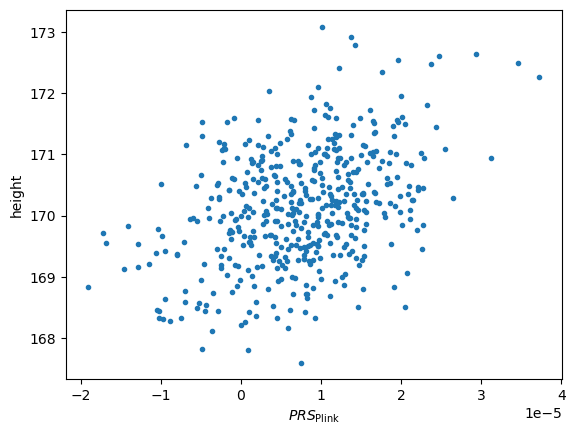

In [4]:
# plink
Output_dir = 'PGS_plink'
Data_prefix = 'EUR'
Pheno_file = '/REF/examples/prsice2/EUR.height'
best_fit_file = 'best_fit_prs.csv'

best_fit = pd.read_csv(os.path.join(Output_dir, best_fit_file))

# scores
scores_plink = pd.read_csv(os.path.join(Output_dir, f"{Data_prefix}.{best_fit['Threshold'].values[0]}.profile"), delim_whitespace=True)

# pheno
pheno = pd.read_csv(Pheno_file, delim_whitespace=True)

# extract valids
pheno_list = []
for fid, iid in scores_plink[['FID', 'IID']].values:
    row = pheno[(pheno['FID'] == fid) & (pheno['IID'] == iid)]
    # fill in NaN if value is missing
    if row.size == 0:
        row = pd.DataFrame(data=[['FID', 'IID', np.nan]], columns=pheno.columns)
    pheno_list += [row]
pheno_list = pd.concat(pheno_list, ignore_index=True)

# plot SCORE vs measured HEIGHT
plt.plot(scores_plink['SCORE'], pheno_list['Height'], '.')
plt.xlabel('$PRS_\mathrm{Plink}$')
plt.ylabel('height')

Text(0, 0.5, 'height')

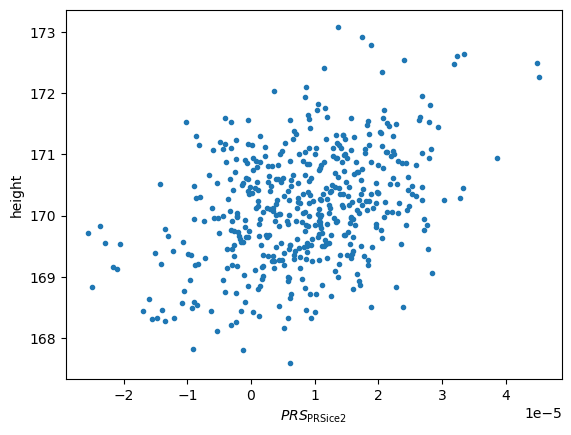

In [5]:
# PRSice-2
Output_dir = 'PGS_prsice2'
Data_prefix = 'EUR'
Pheno_file = '/REF/examples/prsice2/EUR.height'
best_fit_file = f'{Data_prefix}.best'

# scores
scores_prsice2 = pd.read_csv(os.path.join(Output_dir, best_fit_file), delim_whitespace=True)

# pheno
pheno = pd.read_csv(Pheno_file, delim_whitespace=True)

# extract valids
pheno_list = []
for fid, iid in scores_prsice2[['FID', 'IID']].values:
    row = pheno[(pheno['FID'] == fid) & (pheno['IID'] == iid)]
    # fill in NaN if value is missing
    if row.size == 0:
        row = pd.DataFrame(data=[['FID', 'IID', np.nan]], columns=pheno.columns)
    pheno_list += [row]
pheno_list = pd.concat(pheno_list, ignore_index=True)

# plot SCORE vs HEIGHT
plt.plot(scores_prsice2['PRS'], pheno_list['Height'], '.')
plt.xlabel('$PRS_\mathrm{PRSice2}$')
plt.ylabel('height')

Text(0, 0.5, 'height')

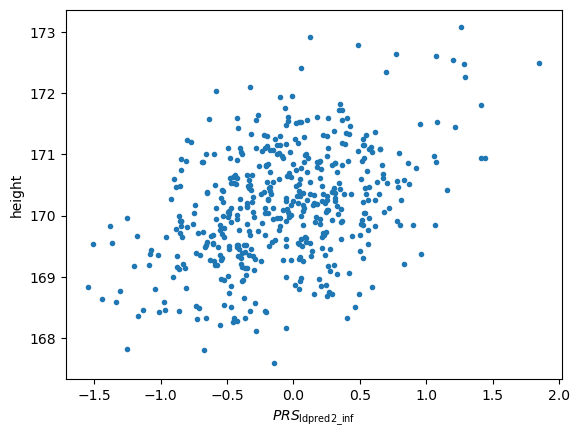

In [6]:
# LDpred2 infinitesimal model
Output_dir = 'PGS_LDpred2_inf'
# Data_prefix = 'EUR'
Pheno_file = '/REF/examples/prsice2/EUR.height'
best_fit_file = 'test.score'

# scores
scores_ldpred2_inf = pd.read_csv(os.path.join(Output_dir, best_fit_file), delim_whitespace=True)

# pheno
pheno = pd.read_csv(Pheno_file, delim_whitespace=True)

# extract valids
pheno_list = []
for fid, iid in scores_ldpred2_inf[['FID', 'IID']].values:
    row = pheno[(pheno['FID'] == fid) & (pheno['IID'] == iid)]
    # fill in NaN if value is missing
    if row.size == 0:
        row = pd.DataFrame(data=[['FID', 'IID', np.nan]], columns=pheno.columns)
    pheno_list += [row]
pheno_list = pd.concat(pheno_list, ignore_index=True)

# plot SCORE vs HEIGHT
plt.plot(scores_ldpred2_inf['score'], pheno_list['Height'], '.')
plt.xlabel('$PRS_\mathrm{ldpred2\_inf}$')
plt.ylabel('height')

Text(0, 0.5, 'height')

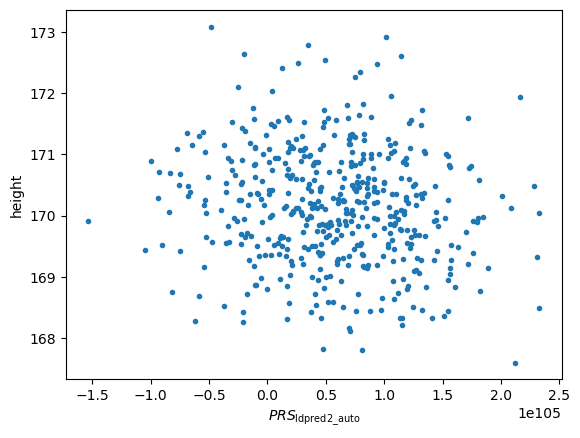

In [7]:
# LDpred2 automatic model
Output_dir = 'PGS_LDpred2_auto'
# Data_prefix = 'EUR'
Pheno_file = '/REF/examples/prsice2/EUR.height'
best_fit_file = 'test.score'

# scores
scores_ldpred2_auto = pd.read_csv(os.path.join(Output_dir, best_fit_file), delim_whitespace=True)

# pheno
pheno = pd.read_csv(Pheno_file, delim_whitespace=True)

# extract valids
pheno_list = []
for fid, iid in scores_ldpred2_auto[['FID', 'IID']].values:
    row = pheno[(pheno['FID'] == fid) & (pheno['IID'] == iid)]
    # fill in NaN if value is missing
    if row.size == 0:
        row = pd.DataFrame(data=[['FID', 'IID', np.nan]], columns=pheno.columns)
    pheno_list += [row]
pheno_list = pd.concat(pheno_list, ignore_index=True)

# plot SCORE vs HEIGHT
plt.plot(scores_ldpred2_auto['score'], pheno_list['Height'], '.')
plt.xlabel('$PRS_\mathrm{ldpred2\_auto}$')
plt.ylabel('height')

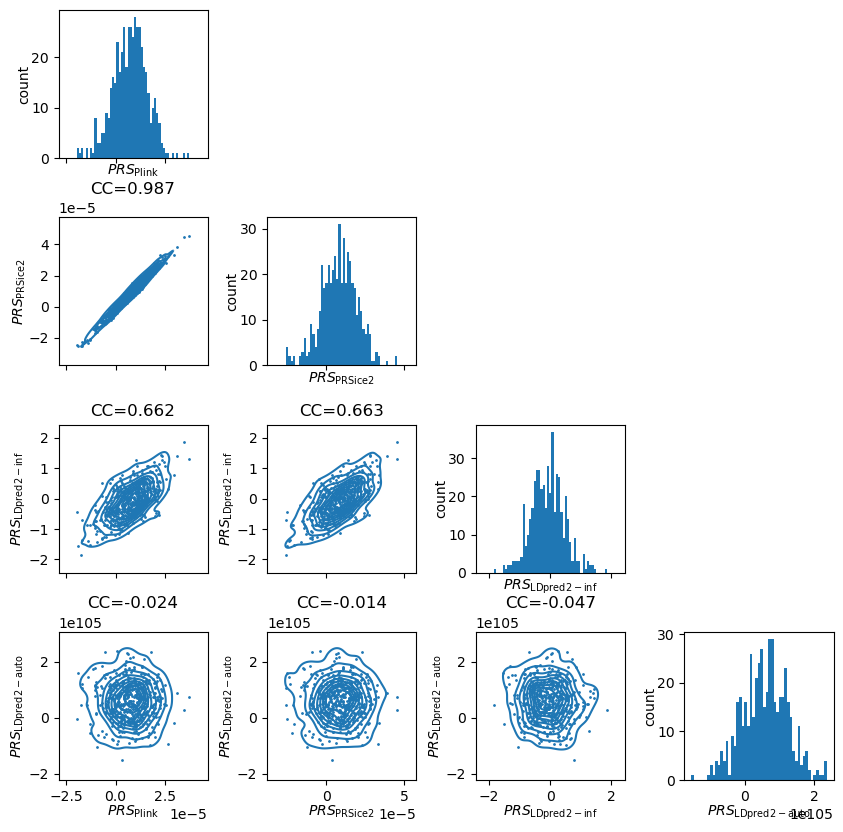

In [8]:
# compare scores and distributions
all_scores = [scores_plink, scores_prsice2, scores_ldpred2_inf, scores_ldpred2_auto]
columns = ['SCORE', 'PRS', 'score', 'score']
labels = [r'$PRS_\mathrm{Plink}$', r'$PRS_\mathrm{PRSice2}$', 
          r'$PRS_\mathrm{LDpred2-inf}$', r'$PRS_\mathrm{LDpred2-auto}$']

fig, axes = plt.subplots(len(all_scores), len(all_scores), figsize=(10, 10), sharex='col')
fig.subplots_adjust(wspace=0.4, hspace=0.4)

for i in range(len(all_scores)):
    y = all_scores[i][columns[i]]
    for j in range(len(all_scores)):
        x = all_scores[j][columns[j]]
        if i < j:
            axes[i, j].set_visible(False)
        elif i==j:
            axes[i, j].hist(x, bins=51)
            axes[i, j].set_ylabel('count', labelpad=0)
            axes[i, j].set_xlabel(labels[i], labelpad=0)
        elif i > j:
            sns.kdeplot(x=x, 
                        y=y,
                        ax=axes[i, j])
            axes[i, j].plot(x, y, 'C0.', ms=2)
            axes[i, j].set_xlabel(labels[j], labelpad=0)
            axes[i, j].set_ylabel(labels[i], labelpad=0)
            axes[i, j].set_title(f'CC={np.corrcoef(x, y)[1, 0]:.3f}')

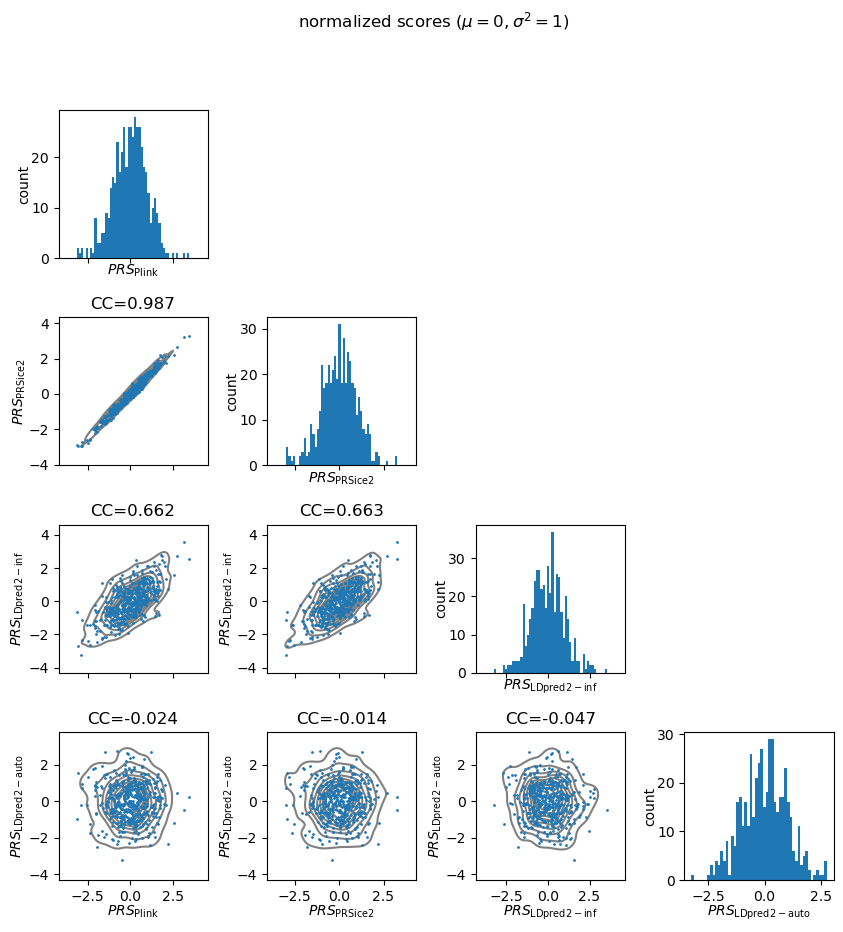

In [9]:
# compare scores and distributions
all_scores = [scores_plink, scores_prsice2, scores_ldpred2_inf, scores_ldpred2_auto]
columns = ['SCORE', 'PRS', 'score', 'score']
labels = [r'$PRS_\mathrm{Plink}$', r'$PRS_\mathrm{PRSice2}$', 
          r'$PRS_\mathrm{LDpred2-inf}$', r'$PRS_\mathrm{LDpred2-auto}$']

fig, axes = plt.subplots(len(all_scores), len(all_scores), figsize=(10, 10), sharex='col')
fig.subplots_adjust(wspace=0.4, hspace=0.4)
fig.suptitle(f'normalized scores ($\mu=0, \sigma^2=1$)')

for i in range(len(all_scores)):
    y = ztransform(all_scores[i][columns[i]])
    for j in range(len(all_scores)):
        x = ztransform(all_scores[j][columns[j]])
        if i < j:
            axes[i, j].set_visible(False)
        elif i==j:
            axes[i, j].hist(x, bins=51)
            axes[i, j].set_ylabel('count', labelpad=0)
            axes[i, j].set_xlabel(labels[i], labelpad=0)
        elif i > j:
            sns.kdeplot(x=x, 
                        y=y,
                        ax=axes[i, j],
                        color='gray')
            axes[i, j].plot(x, y, 'C0.', ms=2)
            axes[i, j].set_xlabel(labels[j], labelpad=0)
            axes[i, j].set_ylabel(labels[i], labelpad=0)
            axes[i, j].set_title(f'CC={np.corrcoef(x, y)[1, 0]:.3f}')

fig.savefig('vis_pgs_normalized_scores.pdf')